<font size=6> <b> 5 주차 강의 Notebook </b> </font>
<div class="alert alert-block alert-success">
  클리앙 사이트에서 글을 scrap하고, 그 내용을 분석해 보자! <br>
</div>
<p style="text-align:right;"> sumyeon@gmail.com </p>

- 사전 설치 필요한 패키지들

> pip install --upgrade pip <br>
> pip install konlpy <br>
> pip install gensim <br>
> pip install wordcloud <br>

 <hr>

# Preparation

In [1]:
import requests
from bs4 import BeautifulSoup
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time

%matplotlib inline

# Data Scrap

In [ ]:
proxies={"https":"https://168.219.61.252:8080", "http":"http://168.219.61.252:8080"}
proxies=None
clienURL= "https://www.clien.net/service/board/"

In [ ]:

def retrieveURLasBSObj(siteurl):
    """
    retrieve the web content of the URL in the form of BeautifulSoup object
    """
    
    page = requests.get(siteurl, proxies=proxies, verify=False) #Request(siteurl, headers={'User-Agent': 'Mozilla/5.0'})
    bsobj = BeautifulSoup(page.text, "html.parser")
    return bsobj

def cleanhtml(rawhtml):
    """
    transform the rawhtml into plain text : (ex, remove html tags such as <p> <div>)
    """
    cleanregex = re.compile('<.*?>')
    cleantext = re.sub(cleanregex,'', rawhtml)
    return cleantext.replace('\n','')

In [ ]:
def retrieveArticle(articleid, bboard='park'):
    """
    retrieve the article information of the given article id.
    
    Parameters:
        articleid (int): article number id
        bboard (str): bulleting board name such as 'park','jirum',etc.
        
    Returns:
        tuple (bboard, articleid, title, create_time, author_id, author_ip, content, reply_count, symph_count, view_count):
            bboard (str): bulletin board name
            articleid (str): article number id
            title (str): article title
            create_time (str): creation time in the form of "2020-07-27 21:04:21"
            author_id (str): article author id
            author_ip (str): ip ex) 223.♡.21.155
            content (str): article content
            reply_count (str): the number of replies
            symph_count (str): the number of symphathy clicks
            view_count (str): the number of view
    """

    targetUrl = clienURL+"/"+bboard+"/"+str(articleid)

    bsobj = retrieveURLasBSObj(targetUrl)
    if bsobj is None:
        return None
        
    bsobj = bsobj.find('div', attrs={'class' : 'content_view'})
    if bsobj is None:
        return None    # sometimes, login page popped up

    # title : <h3 class="post subject"  ...> title </h3>
    title_h3 = bsobj.find('h3', attrs={'class' : 'post_subject'}).span.get_text()
    title = title_h3.replace('\n',' ').replace('\r','').replace('|','')

    symph_div = bsobj.find('div', attrs={'class' : 'post_symph view_symph'})
    if symph_div is None:
        symph_count = 0
    else:
        symph_count = symph_div.get_text()
        symph_count = (int)(symph_count.replace('\n', ' ').replace('\r', ''))

        
    view_count = bsobj.find('div', attrs={'class' : 'view_info'}).get_text()
    view_count = (int)(view_count.replace('\n', ' ').replace('\r', '').replace(',', ''))
    
    content_div = bsobj.find('div', attrs={'class':'post_article'})
    content = cleanhtml( content_div.body.get_text().strip().replace('|','') ) 

    
    author_div = bsobj.find('div', attrs={'class' : 'post_author'})
    author_span = author_div.find_all('span', attrs={'class': None})
    create_time = author_span[0].text.split('\n')[1].strip() 
    author_ip = author_span[-1].text.strip()
    
    
    authorid_span = bsobj.find('span', attrs={'class':'contact_name'})
    if authorid_span.find('img'):
        author_id =authorid_span.find("img")['alt']
    else:
        author_id = authorid_span.find_all('span')[0].text.replace('\n', ' ').replace('\r', '').replace(',', '').strip()

    reply_count_text= bsobj.find('div', attrs={'class' : 'comment_head'}).get_text()
    reply_count = (int)(re.findall('\d+', reply_count_text)[0])

    return (bboard, str(articleid), title, create_time, author_id, author_ip, content, str(reply_count), str(symph_count), str(view_count))

In [ ]:
header = "board|articleid|title|create_time|author_id|author_ip|content|reply_cnt|symph_cnt|view_cnt"

def clien_article_download(bboard, startid, endid, filename):
    with open(filename,"w", encoding='utf-8') as ofile:
        ofile.write(header+"\n")
        for articleid in range(startid,endid, 1):
            article_tuple = retrieveArticle(articleid, 'park')
            if article_tuple is not None:
                ofile.write("|".join(article_tuple)+'\n')
            time.sleep(0.1)
            if not articleid % 1000:
                time.sleep(10)

In [ ]:
clien_article_download('park', 15242011,15261076, "c:/temp/clien_park_aug_5to10.csv")

 <hr>

# Data Loading

In [2]:
df = pd.read_csv("clien_park_aug_5to10.csv", sep='|', error_bad_lines=False, parse_dates=[3])

<div class="alert alert-block alert-info">
<b> Tip:</b> 앞서 배운대로 오류가 생길 경우, 무시할 수준이라고 판단된다면 error_bad_lines로 무시하고 loading </b>

</div>

In [3]:
df.head()

,board,articleid,title,create_time,author_id,author_ip,content,reply_cnt,symph_cnt,view_cnt
0,park,15242011,익스플로러가 느린 이유,2020-08-05 00:01:04,내일은$,218.♡.42.208,얼마전 초딩 아들이 어느 인터넷으로 공부하는 사이트를 사용하더니 저에게 묻습니다아들...,11,2,3208
1,park,15242012,수요일 자정 러블리즈 입니다. [8/4 단신] (데뷔로부터 2095일),2020-08-05 00:02:03,224-rainbow,115.♡.203.252,카메오(Musical Ver.) 작업 트랙 공개 & 분석(1)[공식] tvN 새 예...,14,10,496
2,park,15242014,제 나이는 여름에는 쿨 이었는데...,2020-08-05 00:02:19,화이트덕,125.♡.110.208,1.코요테가 이렇게 옛날 감성으로 돌아오니 좋네요.2.신지씨 특유의 음 끝 바이브레...,1,0,936
3,park,15242018,어느 여자사람의 셀프네일 도전기,2020-08-05 00:04:35,해리비안의 캐적,49.♡.102.42,클리앙에서 이과천재들의 전자기기 후기들을 보며 1도 이해할수 없는 용어의 홍수속에서...,51,24,11075
4,park,15242019,아이맥 2020 업데이트,2020-08-05 00:04:54,Daspfel,125.♡.240.232,27인치만 나왔네요. 예상대로 디자인 변화 없이 내부만 업데이트. 10 세대 인텔 ...,8,0,2014


In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth',1000)

<div class="alert alert-block alert-info">
<b> Tip:</b> pandas의 option 설정으로, Dataframe의 출력 갯수 및 컬럼 길이를 변화시켜 자연어 처리를 준비 </b>

</div>

 <hr>

# 한글 NLP 패키지 로딩

In [5]:
from konlpy.tag import Hannanum, Kkma, Komoran, Okt, Mecab
from konlpy.utils import pprint

In [6]:
tagger = Okt() # Hannanum()  #Kkma()

<div class="alert alert-block alert-info">
<b> Tip:</b> 한글 처리 엔진은 여러 종류가 지원된다. 장단점을 살펴보고 가장 적합한 엔진을 선택하면 된다. </b> <br>
   엔진별 성능 비교  => https://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221337575742 
</div>

<div class="alert alert-block alert-info">
<b> Tip:</b> 카카오에서 만든 Khaii라는 한글 처리기가 성능이 뛰어난 것으로 알려려 있음. 실전에 사용에 추천 (https://github.com/kakao/khaiii). </b>
</div>

 <hr>

# 통계 분석
 - title과 content에서 unpack과 관련된 내용을 찾아, 통계를 내어 보자

##  Title/Content를 하나의 content로 처리, whitespace 제거, URL 제거

In [7]:
df['all_content'] = df.apply(lambda row: '.'.join([str(row['title']), str(row['content'])]), axis=1 )


In [8]:
df['all_content'] = df['all_content'].apply(lambda x : re.sub(r'https?://\S+', '', str(x)))


In [9]:
df['all_content'] = df['all_content'].apply(lambda x: str(x).replace(u'\xa0', u' '))


## Title/Content에서 명사만을 뽑아보자

In [10]:
import ast
df = pd.read_csv("clien_park_aug_5to10_with_nouns.csv", converters={11:ast.literal_eval})

<div class="alert alert-block alert-info">
<b> Tip:</b> pd.read_csv를 이용해 저장된 데이터를 읽어올때, str으로 저장된 list를 복원하기 위해 Abstract Syntax Tree (ast)의 literal_eval 활용 </b>
</div>

## 언팩과 관련된 단어 리스트를 만들고, 해당 단어가 나타나는 article을 찾아보자

In [11]:
filter_keywords = "노트20 note20 갤럭시노트 언팩 버즈 와치".split()

In [12]:
filter_keywords

['노트20', 'note20', '갤럭시노트', '언팩', '버즈', '와치']

In [13]:
df['interest_list'] = df['nouns'].apply(lambda nouns: [ (keyword in nouns) for keyword in filter_keywords])
df['interest'] = df['interest_list'].apply(lambda interest_list : np.sum(interest_list))

In [14]:
df['interest'] = df['nouns'].apply(lambda nouns: sum([ (keyword in nouns) for keyword in filter_keywords]))

<div class="alert alert-block alert-info">
<b> Tip:</b> 가독성을 위해 두 개의 sentence로 나누어 작업했으나, 아래와 같이 하나의 sentence로 처리 가능 </b> <br><br>
<pre>
  df['interest'] = df['nouns'].apply(lambda nouns: sum([ (keyword in nouns) for keyword in filter_keywords]))
</pre>
</div>

## 날짜별로 언팩 관련 article 비율 확인

In [15]:
df['create_time'] = pd.to_datetime(df['create_time'], infer_datetime_format=True)
df['date'] = df['create_time'].dt.date

In [16]:
statdf = df.groupby('date').agg(totalcnt=('interest','count'), galaxycnt=('interest',np.count_nonzero))
statdf

,totalcnt,galaxycnt
date,,
2020-08-05,2291,79
2020-08-06,2755,143
2020-08-07,2319,56
2020-08-08,1784,24
2020-08-09,1648,20
2020-08-10,1623,15


<AxesSubplot:xlabel='date'>

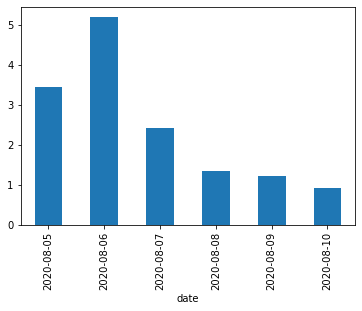

In [17]:
statdf['ratio'] = statdf['galaxycnt'] / statdf['totalcnt'] * 100
statdf['ratio'].plot(kind='bar')

## 언팩 관련 오피니언 리더 확인?

In [18]:
cntdf = df[ df.interest > 0].groupby('author_id').agg(cnt=('title','count')).sort_values(by='cnt', ascending=False)

In [19]:
cntdf.head(10)

,cnt
author_id,
fiat,9
도라에몽펀치,8
요트맨,7
이리야즈,7
그물새,6
또하나의가족,6
TIME_TRAVELER,4
SovereignLightCafe,4
쉭한도시남자,4


array([[<AxesSubplot:title={'center':'cnt'}>]], dtype=object)

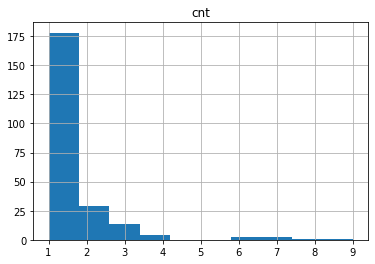

In [20]:

cntdf.hist()

##  언팩 관련 article의 긍부정 여부를 확인해 보자!
 - 한국어 감성 사전 ( https://github.com/park1200656/KnuSentiLex )을 활용해 보자

<b> 감성 사전의 내용 샘플 </b>
<pre>
[
{
	"word": "(-;",
	"word_root": "(",
	"polarity": "1"
},
{
	"word": "(;_;)",
	"word_root": "(;_;)",
	"polarity": "-1"
},
...
{
	"word": "(^^)",
	"word_root": "(^^)",
	"polarity": "1"
},
]
</pre>

<div class="alert alert-block alert-info">
<b> Tip:</b> 한국어 감성 사전을 활용, 긍정의 단어가 많은 경우 긍정의 article로 반대의 경우 부저의 article로 판단
</div>

<b> 감성 사전 데이터 로딩 </b>

In [21]:
import json
with open('SentiWord_info.json', encoding='utf-8', mode='r') as f:
    data = json.load(f)

<b> 단어 : 긍부정점수 형태의 dict 로 변환 </b>

In [22]:
polarity_dict = { item['word'] : item['polarity'] for item in data}

<b> 언팩 관련된 article만을 모아 별도의 Dataframe 구성 </b>

In [23]:
focusdf = df[ df.interest > 0]

<b> article내 단어들의 긍부정을 sum해서 article 전체의 긍부정 판단 </b>

In [24]:
focusdf['polarity'] = focusdf['nouns'].apply(lambda x : np.sum([ int(polarity_dict.get(noun, 0)) for noun in x]) )

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<b> 긍부정 점수의 histogram을 보자</b>

<AxesSubplot:>

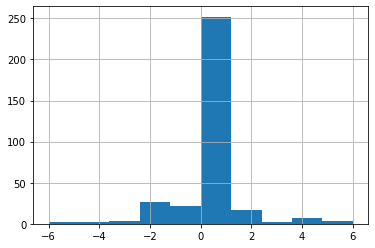

In [25]:
focusdf['polarity'].hist()

<b> 긍부정 점수로 긍정(positive), 부정 (negative), 중립 (neutral) 구성</b>

In [26]:
focusdf['sentiment'] = 'neutral'
focusdf['sentiment'] = focusdf['sentiment'].where( focusdf['polarity'] >= 0, 'negative' )
focusdf['sentiment'] = focusdf['sentiment'].where( focusdf['polarity'] <= 0, 'positive' )

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

<b> 긍부정으로 구분된 article의 갯수, 글쓴이 숫자 확인</b>

In [27]:
focusdf.groupby('sentiment').agg(article_cnt=('articleid','count'), author_cnt=('author_id','nunique'))

,article_cnt,author_cnt
sentiment,,
negative,56,51
neutral,224,166
positive,57,47


<AxesSubplot:xlabel='date'>

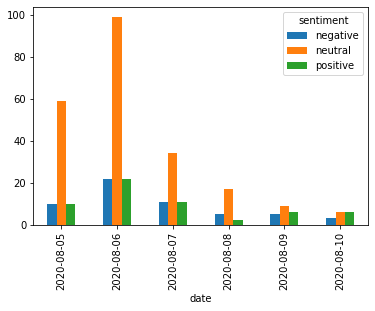

In [28]:
focusdf.groupby(['date','sentiment']).agg(article_cnt=('articleid','count'), author_cnt=('author_id','nunique')).unstack()['article_cnt'].plot(kind='bar')

<div class="alert alert-block alert-warning">
<b> Note:</b> 언팩 후에 negative 성향의 글들이 사라지고, positive한 효과가 나왔다. </b>
</div>

# Word Cloud 생성 (긍/부정의 중심 단어를 찾아보자)

## 긍정 성향의 article의 word cloud 생성

In [29]:
focusdf[ focusdf.sentiment == 'positive'].nouns.values[:3]

array([list(['갤럭시', '언팩', '것', '오늘', '밤', '11시', '시작이긴', '유출', '영상', '들', '싶습니다;;언팩에서', '가격', '사양', '확인', '출시', '일정', '발표', 'ㅎㅎ']),
       list(['갤럭시', '버즈', '라이브', '11번', '재유출(', '+', '예판', '혜택', '버즈', '라이브', '글', '이번', '끝', '거', '어제', '버즈', '라이브', '11번', '글', '어제', '글', '링크', '이', '검색', '줄', '꿈', '몇', '시간', '뒤', '버즈', '플러스', '줄', '전', '검색', '곳', '버즈', '라이브', ';;(네이버', '버즈', '플러스', '최고', '순', '정렬하시', '96만원', '담당자', '것', '링크', '모바일', '네이버', '검색', '버즈', '플러스', '검색', '최고', '96만원', '클릭하시', '가격', '경유', '1', '할인가격', '19.8', '것', '같구', '예판', '혜택', '케이스', '5', '할인쿠폰', '자세한', '거', '페이지', '참조']),
       list(['안드로이드', '플랫폼', '100', '만족', '불가능', '10년', '안드로이드', '1년', '외도', '안드로이드', '생각인데요', '안드로이드만', '죽', '때', '경직적', '자유도', '쓰레기', '정도', '인식', '장점', '눈', '시작', '미', '아주아주', '탭틱엔진', '촉감(알람앱', '다이얼', '때', '다들', '아실거에요', 'ㅎㅎ),', '듯', '지원', '기간', '등등', '좋은걸', '안드로이드', '이것들', '그리워지는거', '예전', '줄', '것들', '눈', '시작', '안드로이드', '때', '안드로이드', '뭔가', '부족', '다음폰', '노트21', '정도', '것', '데', '그때', '갤럭시노트', '기가막히', '

In [30]:
from itertools import chain
flat_words = list(chain( *(focusdf[ focusdf.sentiment == 'positive'].nouns.values)))

## 불용어 (stopword 제거)
 - 한국어 불용어 사전 ( https://www.ranks.nl/stopwords/korean )을 활용해서 불용어를 제거하자

In [31]:
stopwords = []
with open('korean_stopwords.txt','r', encoding='utf_8') as infile:
    for line in infile:
        stopwords.append(line.strip())

In [32]:
stopwords[:10]

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']

In [33]:
meaningful_words = [word for word in flat_words if word not in stopwords]

In [34]:
from collections import Counter
cnt = Counter(meaningful_words)
cnt.most_common(20)

[('버즈', 33),
 ('갤럭시', 32),
 ('노트20', 32),
 ('생각', 27),
 ('라이브', 26),
 ('사용', 22),
 ('언팩', 19),
 ('노트', 16),
 ('이', 15),
 ('삼성', 15),
 ('ㅎㅎ', 14),
 ('구매', 14),
 ('수', 12),
 ('오픈형', 12),
 ('가격', 11),
 ('데', 11),
 ('안드로이드', 10),
 ('3년', 10),
 ('T다이렉트샵', 10),
 ('노캔', 9)]

## 단어:발생횟수 형태의 dict 생성

In [35]:
tags = {word:count for (word,count) in cnt.most_common(50)}

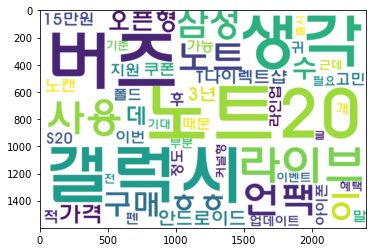

In [36]:
from wordcloud import WordCloud

wc = WordCloud(background_color='white',font_path='C:\\WINDOWS\\Fonts\\HYWULM.TTF',  width=1200, height=800, scale=2.0, max_font_size=250)
gen =wc.generate_from_frequencies(tags)
plt.imshow(gen, interpolation='bilinear')

# 클러스터링

## sentence를 vector화 하자

In [37]:
from gensim.test.utils import common_texts

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [38]:
documents = [ TaggedDocument(row[12],[row[0]]) for row in focusdf.itertuples()]

In [39]:
model = Doc2Vec(documents, vector_size=50)

In [40]:
focusdf['vec'] = focusdf['nouns'].apply(lambda x: model.infer_vector(x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Clustering

In [41]:
# Number of cluster chosen is 3 based on Elbow Method, please check the full code for it
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
focusdf['cluster'] = kmeans.fit_predict(focusdf['vec'].values.tolist())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [42]:
focusdf.groupby('cluster').agg(cnt=('nouns','count'))

,cnt
cluster,
0,135
1,4
2,20
3,52
4,126


In [43]:
focusdf[focusdf.cluster == 0][['title','content']]

,title,content
31,노트20 제정신인가요?.jpg,120만원 가격 책정해놓고 노트9에 썼던 디스플레이 주사율 60너프 뒷면 플라스틱 기본앱에 광고까지 집어넣고 os업뎃은 2번이면 끝나고 플래그쉽 급나누기는 중국보다 심하네요 화웨이도 저러지는 않을테데;;; s10 놋10이 잘만든거였어요 ㅋㅋㅋㅋ 정점을 찍고 급추락
399,"갤 노트20 ‘리뷰’ 영상, 언팩 25시간 전 유튜브에…관리의 삼성 ‘구멍’.gisa","http://www.m-i.kr/news/articleView.html?idxno=735276이로써 알려진 사실모서리가 둥글게 처리, 펀치홀 더 큼, 뒷면 플라스틱 재질, 구형 AMOLED 사용, 120hz 미지원 등등노트20은 노트20 울트라와 완전히 급이 다른걸로 확인.... 노트20 라이트라고 불러야 할것 같네요."
531,노트20이 플라스틱이라니...,노트 울트라는 그렇게 비싸게 내놓고... 노트20은 여러모로 빼는 게 많네요. 재질까지...s20 판매량 몰아주기인가요 이거...
617,유튜버가 노트20 영상을 사전에 올렸었군용..,제가 그 때 바로 알았다면 영상을 다운로드 했었을텐데!!못봐서 아쉽습니다...
646,갤럭시폴드2 방수방진 되는지 안되는지 아직도 미확정인거 맞죠 ?,가능성 제기라는 기사는 있던데 결국 언팩에서 공개되려나요 저는 디자인이고 뭐고보다 폴더폰은 방수방진이 되면 그때서나 사려고 했어서 그게 제일 중요한데 지금 투폰 중 안드로이드폰은 노트8이라 슬슬 업그레이드 고려해야 하거든요 빨리 방수방진 폴더폰 나왔으면 좋겠습니다
...,...,...
10978,LG 벨벳 정가에 사기 vs 삼성 갤럭시노트20(울트라x) 정가에 사기,"누가 더 ㅎㄱ같을까요?전 개인적으론 노트20 나오기전까진 전자인줄 알았는데, 노트20이 나오니 후자같네요."
11088,QCY T1 고장이 안 나네요..,15000원에 구매해서 2년째 사용중인데 가성비는 말할것도 없고 뽑기를 잘 한건지 아직까지 큰 문제 없이 사용중입니다.유닛도 두어번 정도 떨궜는데도 괜찬네요.개인적으로 먹먹한 느낌이 별로라 오픈형을 선호해서 버즈 라이브로 넘어갈까 싶은데 아직까지 너무 멀쩡해서 고민이네요 ㅎㅎ 고장날때까지 일단 버텨볼까 하는데 T1 쓰시는 분들은 고장없이 잘 쓰고들 계신가요?
11112,버즈 라이브와 에어팟프로 지하철에서 비교 사용해보는데,더 자세히 리뷰하기위해출근길에 번갈아 써봤는데 출근때 처음에 버즈라이브를 끼우다가에어핏 프로로 바꿔 끼우니 차이가 더 명확해지긴 하네요 오픈형이라해도 특이한 구조라서 그냥 들어도에어팟보다는 노래가 더 잘들립니다 노캔 켜면 그래도 노래 들을만 하네요. 소음이 얕게 캔슬링 되긴한데진짜오묘하게 되네요/GreenteaCat
11323,버즈 라이브 실리콘 캡 수령 방법 입니다.,직접 방문해 수령해서 글 내용 추가 합니다제가 방문한 곳은 as센터+디프 복합인데 as접수를 통해접수 하니 디프 컨설턴트 분들을 통해 실리콘 팁 수령 했습니다.디프에서 준다고 해서 문의 하니 아예 뭔 소린지를 모르더라구요. 그래서 삼성 고객센터를 통해 버즈 담당 고객센터로 문의 하니 섭센에서 제공이라고 답변 받았습니다.그리고 매뉴얼상으론 그냥 가서 받으러 왔다고 하면 주는게 아니라 as 접수 후 귀에서 헐렁이는지 체크 후 제공 한다고하네요.(개인적인 생각으론 형식적인 절차가 아닐까 싶습니다)흰색인데 흰색은 아직 없어서 전 존버 해야겠습니다ㅜㅜ


##  Visualization - PCA

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
focusdf['x'] = pca.fit_transform(focusdf['vec'].values.tolist())[:,0]
focusdf['y'] = pca.fit_transform(focusdf['vec'].values.tolist())[:,1]
focusdf['z'] = pca.fit_transform(focusdf['vec'].values.tolist())[:,2]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

## Visualization - 2d

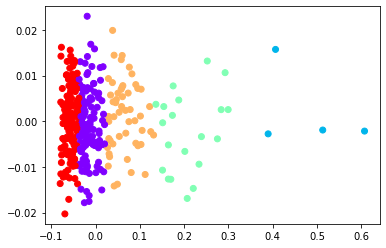

In [45]:
import matplotlib.pyplot as plt

plt.scatter(focusdf['x'], focusdf['y'], c=focusdf['cluster'], cmap='rainbow')

## Visualization - 3d

Text(0.5, 0.92, 'Clien Article Clustering (using K Means)')

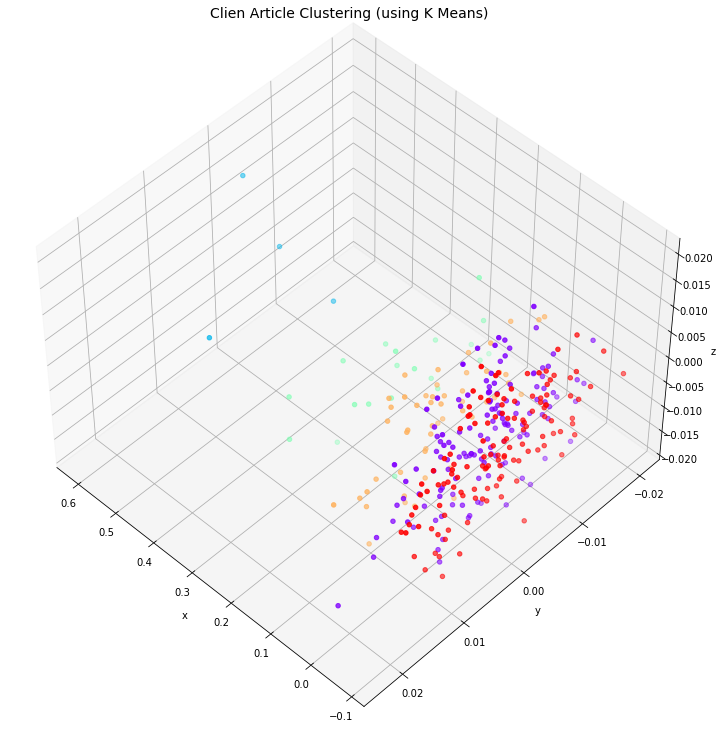

In [46]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(focusdf['x'],focusdf['y'],focusdf['z'], c=focusdf['cluster'], cmap='rainbow')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_facecolor('white')
plt.title("Clien Article Clustering (using K Means)", fontsize=14)

## Cluster Common words

In [47]:
cluster_flatwords = {}
for cluster_num in focusdf['cluster'].unique():
    cluster_flatwords[cluster_num] = list(chain( *(focusdf[ focusdf.cluster == cluster_num].nouns.values)))

In [48]:
for cluster_num in cluster_flatwords.keys():
    cluster_flatwords[cluster_num] = [word for word in cluster_flatwords[cluster_num] if word not in stopwords]

In [49]:
cluster_counters = {}
for cluster_num in cluster_flatwords.keys():
    cluster_counters[cluster_num] = Counter(cluster_flatwords[cluster_num])

In [50]:
for cluster_num in cluster_counters.keys():
    print(cluster_num)
    print(cluster_counters[cluster_num].most_common(10))

0
[('노트20', 77), ('버즈', 50), ('언팩', 40), ('라이브', 36), ('울트라', 24), ('삼성', 23), ('갤럭시', 19), ('노트', 16), ('폴드2', 16), ('구매', 16)]
4
[('노트20', 59), ('언팩', 49), ('버즈', 43), ('라이브', 35), ('갤럭시', 22), ('삼성', 20), ('폴드2', 13), ('카툭튀', 11), ('이번', 11), ('케이스', 10)]
3
[('노트20', 37), ('버즈', 32), ('라이브', 26), ('삼성', 24), ('갤럭시', 20), ('생각', 18), ('울트라', 17), ('소리', 16), ('노트', 16), ('수', 15)]
2
[('버즈', 20), ('라이브', 20), ('카메라', 20), ('갤럭시', 17), ('삼성', 16), ('노트20', 16), ('거', 14), ('수', 14), ('프로', 13), ('생각', 13)]
1
[('사용', 14), ('생각', 12), ('T다이렉트샵', 8), ('쿠폰', 8), ('노트20', 7), ('갤럭시', 6), ('3년', 6), ('삼성', 6), ('지원', 5), ('이', 5)]
